In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from xgboost import XGBRegressor
from custom_functions import processing
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# import data
file_path = 'P:\DATA_OCT_22\Expert_Eye\Dataset\Data\data_v10.xlsx'
df = pd.read_excel(file_path)
dataset = df.copy()
dataset = dataset.drop(['Foldername'], axis=1)

dataset.head()

,Gender,VINCQ32DDN,VINICODEX003,FROPCOM0001,FROPCOM0005,FROPCOM0006_S1_,FROPCOM0006_S2_,FROPCOM0006_S3_,FROPCOM0006_S4_,FROPCOM0006_S5_,...,FROPCOM0004_SQ010_SQ003__1_0_1,FROPCOM0004_SQ010_SQ003__10_0_0,FROPCOM0004_SQ010_SQ003__nan,Frailty_Score,Frailty_State,HADS_D_Score,grip,walk_time_4m,Fried_Score,Fried_State
0,0,76.0,0.0,0.0,3.0,NaN,NaN,NaN,NaN,1.0,...,0,0,1,7,0,9,NaN,8.45,2,0
1,0,75.0,1.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,4,1,9,21.5,6.11,3,1
2,0,67.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,9,0,10,23.2,20.00,2,0
3,0,72.0,1.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,...,0,0,1,7,0,15,17.7,4.87,2,0
4,1,69.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,1,8,0,10,40.0,3.48,1,0


In [4]:
# Models
models = {
    'XGBoost': XGBRegressor(),
    'RandomForest': RandomForestRegressor(),
}

# Parameters
params = {
    'XGBoost': {
        'n_estimators': [50],
        'max_depth': [5, 10],
        'learning_rate': [0.1, 0.2],
    },
    'RandomForest': {
        'n_estimators': [30, 50],
        'max_depth': [5, 8, 10],
        'max_features': ['sqrt', 'log2'],
    }
}

Performing Grid Search for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Performing Grid Search for RandomForest...
Fitting 5 folds for each of 12 candidates, tot

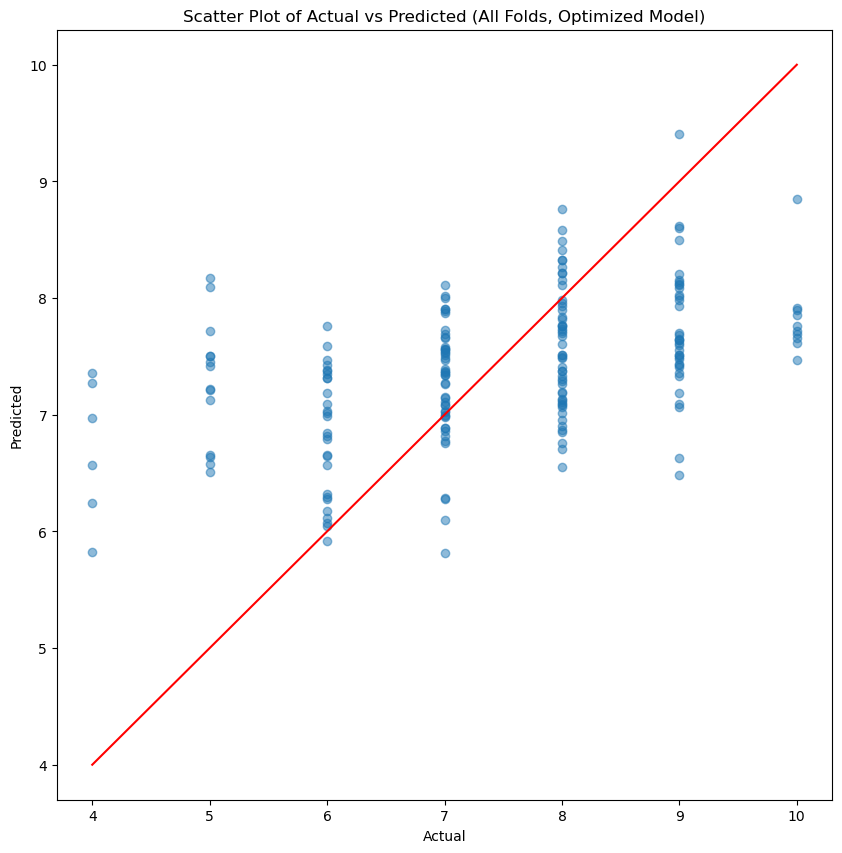

In [10]:
# Initialize lists to store metrics
mse_list = []
mae_list = []
r2_list = []

n_splits = 5

all_y_test = []
all_y_pred = []

X = dataset.drop(['Fried_State', 'Fried_Score', 'Frailty_State', 'Frailty_Score'], axis=1).values
y = dataset['Frailty_Score'].values

kf = KFold(n_splits=5, shuffle=True, random_state=42)

for train_index, test_index in kf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Impute missing values on train set
    X_train_imputed, best_k = processing(X_train, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    # Impute missing values on test set using best k value from train set
    # Scaling first
    Scaler = MinMaxScaler()
    scaler = Scaler.fit(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply KNN imputer to test set
    imputer = KNNImputer(n_neighbors=best_k)
    imputer.fit(X_train)
    X_test_imputed_scaled = imputer.transform(X_test_scaled)

    # Inverse scaling
    X_test_imputed = scaler.inverse_transform(X_test_imputed_scaled)

    for model_name, model in models.items():
        print(f'Performing Grid Search for {model_name}...')

        grid_search = GridSearchCV(estimator=model, param_grid=params[model_name], scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)

        grid_search.fit(X_train_imputed, y_train)

        best_model = grid_search.best_estimator_

        y_pred = best_model.predict(X_test_imputed)

        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        mse_list.append(mse)
        mae_list.append(mae)
        r2_list.append(r2)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

# Calculate mean and std for each metric
mean_mse = np.mean(mse_list)
std_mse = np.std(mse_list)
mean_rmse = sqrt(mean_mse)
std_rmse = sqrt(std_mse)
std_rmse = np.std(rmse_list)
mean_mae = np.mean(mae_list)
std_mae = np.std(mae_list)
mean_r2 = np.mean(r2_list)
std_r2 = np.std(r2_list)

# Print aggregated metrics
print(f'Mean MSE: {mean_mse:.2f} (±{std_mse:.2f})')
print(f'Mean RMSE: {mean_rmse:.2f} (±{std_rmse:.2f})')
print(f'Mean MAE: {mean_mae:.2f} (±{std_mae:.2f})')
print(f'Mean R2: {mean_r2:.2f} (±{std_r2:.2f})')

# Plot average scatter plot
#plt.scatter(y_test, y_pred)
#plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--')
#plt.xlabel('True Values')
#plt.ylabel('Predictions')
#plt.title('Scatter Plot of True vs Predicted values')
#plt.show()

# Scatter plot for all folds
plt.figure(figsize=(10, 10))
plt.scatter(all_y_test, all_y_pred, alpha=0.5)
plt.title('Scatter Plot of Actual vs Predicted (All Folds, Optimized Model)')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.plot([min(all_y_test), max(all_y_test)], [min(all_y_test), max(all_y_test)], 'r')  # Diagonal line
plt.show()
